In [215]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
plt.style.use('bmh')

In [183]:
%run api_binancePrice.ipynb
# import binancePrice
df = pd.read_csv('binance_ETHEUR.csv')
df['datetime'] = pd.to_datetime(df.datetime,format='%Y-%m-%d %H:%M:%S')
df.index = df['datetime']
df.tail()

1     object
2     object
3     object
4     object
5     object
6      int64
7     object
8      int64
9     object
10    object
dtype: object


,datetime,open,high,low,close,volume,close_time,asset_volume,trade_number,taker_buy_base,taker_buy_quote
datetime,,,,,,,,,,,
2020-10-08 13:00:00,2020-10-08 13:00:00,288.98,289.47,287.72,288.77,70.36547,1602158399999,20320.701324,95,52.31775,15120.344858
2020-10-08 14:00:00,2020-10-08 14:00:00,288.51,291.10,288.03,291.10,36.82582,1602161999999,10677.640454,88,33.02291,9576.258429
2020-10-08 15:00:00,2020-10-08 15:00:00,291.10,294.48,290.73,294.31,179.10913,1602165599999,52493.541486,227,138.04180,40428.117818
2020-10-08 16:00:00,2020-10-08 16:00:00,294.48,298.70,292.95,298.70,217.11933,1602169199999,64199.209964,338,168.18394,49737.617948
2020-10-08 17:00:00,2020-10-08 17:00:00,298.75,299.00,297.23,297.23,94.01831,1602172799999,28055.307619,136,73.41427,21913.220728


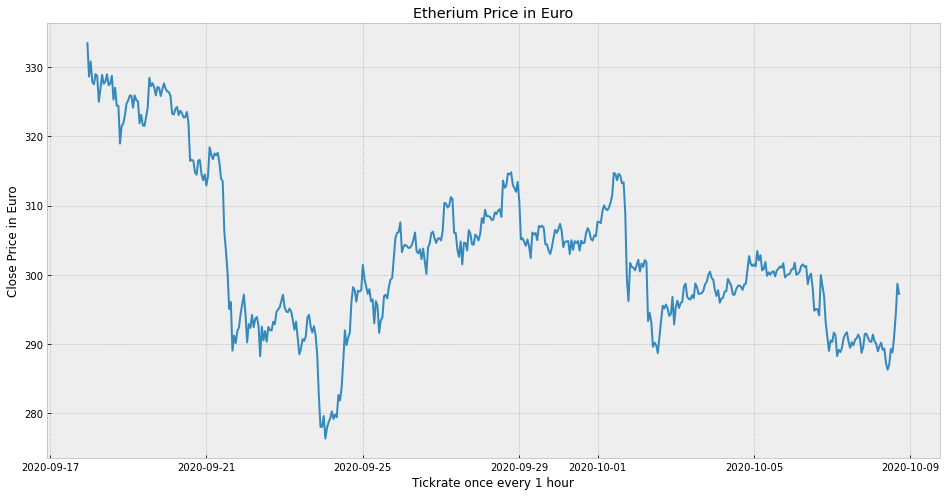

In [218]:
#visualize
plt.figure(figsize=(16,8))
plt.title('Etherium Price in Euro')
plt.xlabel('Tickrate once every 1 hour')
plt.ylabel('Close Price in Euro')
plt.plot(df['close'])

In [219]:
# calculate the percentage change, benefit of normalization, returns have more managable statistical properties 
df['returns'] = df.close.pct_change()
df.head()

,datetime,open,high,low,close,volume,close_time,asset_volume,trade_number,taker_buy_base,taker_buy_quote,returns,log_returns
datetime,,,,,,,,,,,,,
2020-09-17 23:00:00,2020-09-17 23:00:00,333.32,334.42,332.11,333.49,172.75082,1600379999999,57614.679143,163,102.06771,34075.128102,NaN,0.002913
2020-09-18 00:00:00,2020-09-18 00:00:00,333.42,333.61,328.10,328.66,139.97738,1600383599999,46280.287009,178,100.10222,33067.095465,-0.014483,-0.014589
2020-09-18 01:00:00,2020-09-18 01:00:00,329.03,331.51,328.97,330.84,87.69673,1600387199999,28935.421988,101,59.78995,19736.993195,0.006633,0.006611
2020-09-18 02:00:00,2020-09-18 02:00:00,330.55,332.74,327.82,327.89,36.97020,1600390799999,12210.116147,67,28.28552,9349.888550,-0.008917,-0.008957
2020-09-18 03:00:00,2020-09-18 03:00:00,328.44,328.89,326.71,327.55,22.57869,1600394399999,7399.999454,48,17.83705,5846.267732,-0.001037,-0.001037


In [220]:
# use log return when it comes to time series when we try to predict some price. assuming log normality, (prices are normally distributed)
# when returns are very small, log returns ensures prices are close in valut to raw returns
df['log_returns'] = np.log(1+df['returns'])
df.head()

,datetime,open,high,low,close,volume,close_time,asset_volume,trade_number,taker_buy_base,taker_buy_quote,returns,log_returns
datetime,,,,,,,,,,,,,
2020-09-17 23:00:00,2020-09-17 23:00:00,333.32,334.42,332.11,333.49,172.75082,1600379999999,57614.679143,163,102.06771,34075.128102,NaN,NaN
2020-09-18 00:00:00,2020-09-18 00:00:00,333.42,333.61,328.10,328.66,139.97738,1600383599999,46280.287009,178,100.10222,33067.095465,-0.014483,-0.014589
2020-09-18 01:00:00,2020-09-18 01:00:00,329.03,331.51,328.97,330.84,87.69673,1600387199999,28935.421988,101,59.78995,19736.993195,0.006633,0.006611
2020-09-18 02:00:00,2020-09-18 02:00:00,330.55,332.74,327.82,327.89,36.97020,1600390799999,12210.116147,67,28.28552,9349.888550,-0.008917,-0.008957
2020-09-18 03:00:00,2020-09-18 03:00:00,328.44,328.89,326.71,327.55,22.57869,1600394399999,7399.999454,48,17.83705,5846.267732,-0.001037,-0.001037


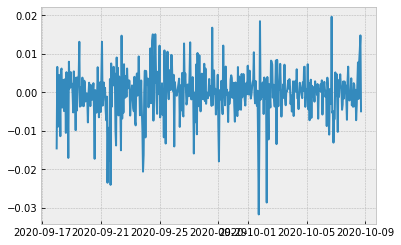

In [221]:
plt.figure(1)
plt.plot(df.log_returns)
# mean is constant, revolves around zero

In [222]:
df.dropna(inplace=True)

In [223]:
len(df)

498

In [224]:
x = df[['close','log_returns']].values

In [225]:
# because features are in different scales, we use minmaxScaler to normalize the data
scaler = MinMaxScaler(feature_range=(0,1)).fit(x)
x_scaled=scaler.transform(x)

In [226]:
x_scaled[:5]

array([[0.96002201, 0.33392831],
       [1.        , 0.74621121],
       [0.94590134, 0.44346252],
       [0.93966624, 0.59746858],
       [0.96680726, 0.7053163 ]])

In [227]:
# y is the target/output
y = [x[0] for x in x_scaled]
y[:3]

[0.9600220062351017, 1.0, 0.9459013387126358]

Train test split with 80/20, split NOT randomly due to time series

In [228]:
split = int(len(x_scaled) * 0.8)
print(split)

398


In [229]:
x_train = x_scaled[:split]
x_test = x_scaled[split:len(x_scaled)]
y_train = y[:split]
y_test = y[split:len(y)]

In [230]:
# checking if those splits are equal
assert len(x_train) == len(y_train)
assert len(x_test) == len(y_test)

In [231]:
# use lstm (long short term memory) to process data in a sequential way. 
# lstm needs number of observations (sample), time steps, features (x)
# set a time step to calculate y at t=1, up until now our target y is just a copy of x.

timestep = 3
xtrain = []
ytrain = []
xtest = []
ytest = []
for i in range(timestep, len(x_train)):
    # 3, 4, 5, .... 398
    xtrain.append(x_train[i-timestep:i,:x_train.shape[1]])
    ytrain.append(y_train[i])
for i in range(timestep, len(x_test)):
    xtest.append(x_test[i-timestep:i,:x_train.shape[1]])
    ytest.append(y_test[i])
    

In [232]:
xtrain[0]

array([[0.96002201, 0.33392831],
       [1.        , 0.74621121],
       [0.94590134, 0.44346252]])

In [233]:
ytrain[0]

0.9396662387676518

In [234]:
# original value of ytrain, and double check with df.head()
val = np.array(ytrain[0])
val = np.c_[val, np.zeros(val.shape)]
scaler.inverse_transform(val)

array([[ 3.27550000e+02, -3.17601815e-02]])

In [235]:
df.head()

,datetime,open,high,low,close,volume,close_time,asset_volume,trade_number,taker_buy_base,taker_buy_quote,returns,log_returns
datetime,,,,,,,,,,,,,
2020-09-18 00:00:00,2020-09-18 00:00:00,333.42,333.61,328.10,328.66,139.97738,1600383599999,46280.287009,178,100.10222,33067.095465,-0.014483,-0.014589
2020-09-18 01:00:00,2020-09-18 01:00:00,329.03,331.51,328.97,330.84,87.69673,1600387199999,28935.421988,101,59.78995,19736.993195,0.006633,0.006611
2020-09-18 02:00:00,2020-09-18 02:00:00,330.55,332.74,327.82,327.89,36.97020,1600390799999,12210.116147,67,28.28552,9349.888550,-0.008917,-0.008957
2020-09-18 03:00:00,2020-09-18 03:00:00,328.44,328.89,326.71,327.55,22.57869,1600394399999,7399.999454,48,17.83705,5846.267732,-0.001037,-0.001037
2020-09-18 04:00:00,2020-09-18 04:00:00,328.03,329.03,328.00,329.03,6.11775,1600397999999,2007.489221,18,5.61641,1842.958378,0.004518,0.004508


In [236]:
xtrain, ytrain = (np.array(xtrain),np.array(ytrain))
xtrain = np.reshape(xtrain, (xtrain.shape[0],xtrain.shape[1],xtrain.shape[2]))

xtest, ytest = (np.array(xtest),np.array(ytest))
xtest = np.reshape(xtest,(xtest.shape[0],xtest.shape[1],xtest.shape[2]))

In [237]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(395, 3, 2)
(395,)
(97, 3, 2)
(97,)


In [238]:
model = Sequential()
model.add(LSTM(4, input_shape=(xtrain.shape[1],xtrain.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(xtrain,ytrain,epochs=100, validation_data=(xtest,ytest),batch_size=16,verbose=1)

Train on 395 samples, validate on 97 samples
Epoch 1/100
395/395 [==============================] - 2s 4ms/sample - loss: 0.1460 - val_loss: 0.0287
Epoch 2/100
395/395 [==============================] - 0s 203us/sample - loss: 0.0609 - val_loss: 0.0047
Epoch 3/100
395/395 [==============================] - 0s 208us/sample - loss: 0.0240 - val_loss: 0.0053
Epoch 4/100
395/395 [==============================] - 0s 205us/sample - loss: 0.0138 - val_loss: 0.0095
Epoch 5/100
395/395 [==============================] - 0s 198us/sample - loss: 0.0122 - val_loss: 0.0105
Epoch 6/100
395/395 [==============================] - 0s 205us/sample - loss: 0.0112 - val_loss: 0.0089
Epoch 7/100
395/395 [==============================] - 0s 208us/sample - loss: 0.0102 - val_loss: 0.0082
Epoch 8/100
395/395 [==============================] - 0s 200us/sample - loss: 0.0091 - val_loss: 0.0070
Epoch 9/100
395/395 [==============================] - 0s 198us/sample - loss: 0.0081 - val_loss: 0.0063
Epoch 10/100

In [239]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 4)                 112       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5         
Total params: 117
Trainable params: 117
Non-trainable params: 0
_________________________________________________________________


In [240]:
trainPredict = model.predict(xtrain)
testPredict = model.predict(xtest)

In [241]:
trainPredict = np.c_[trainPredict, np.zeros(trainPredict.shape)]
testPredict = np.c_[testPredict, np.zeros(testPredict.shape)]

In [242]:
#invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainPredict = [x[0] for x in trainPredict]

testPredict = scaler.inverse_transform(testPredict)
testPredict = [x[0] for x in testPredict]

In [243]:
print(testPredict)

[298.5989326047897, 298.10148642718787, 298.5626485362649, 298.81437159776686, 300.640010997951, 302.5804440447688, 302.4522967818379, 301.85738561898467, 301.42133649915456, 301.4220873048901, 303.23055730551476, 302.5437228187918, 303.2695179477334, 300.93721956104037, 301.02825881928203, 301.39927548646926, 300.46598657935857, 300.5376267725229, 299.8642515349388, 300.6235095229745, 300.63129547595975, 300.1870996263623, 300.6465504834056, 300.91855017513035, 301.5433505567908, 301.32889151155945, 301.81575652867554, 300.14232267737384, 300.0456133732199, 299.77326265543695, 300.3992396244406, 300.8983954289555, 301.05444926351305, 301.8964892718196, 300.5426500204205, 300.4127785044908, 300.2298175475001, 301.36152393400664, 301.77170925885434, 301.5964594992995, 301.4768619960546, 299.1776526907086, 299.6078253743052, 299.75339718073604, 298.86211926728487, 295.4876277640462, 294.5807324412465, 294.5302366927266, 294.5487988206744, 298.6552999141812, 298.70351074308155, 298.393948

In [244]:
testScore = mean_squared_error([x[0][0] for x in xtest], testPredict, squared=False)
print(testScore)

295.3975961890278


In [245]:
len(predictions)

97

E:\AnacondA\envs\matrixai\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


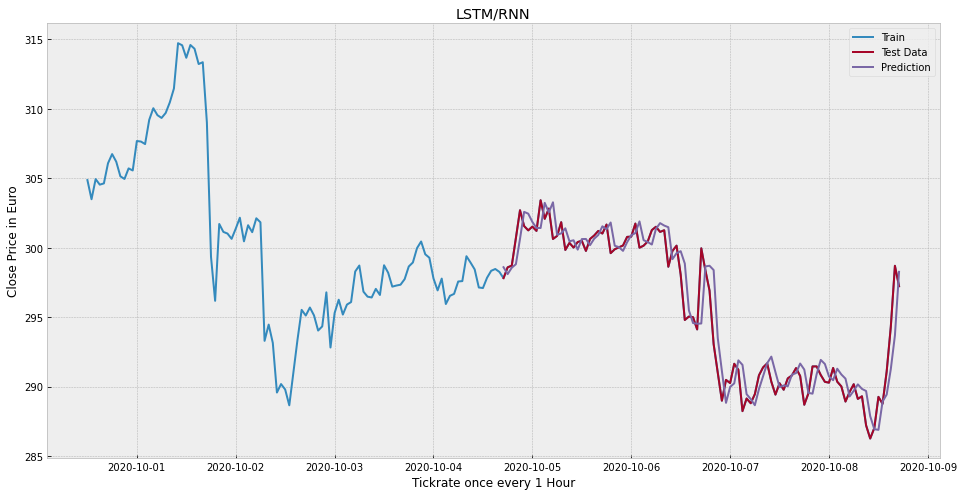

In [247]:
predictions = testPredict

valid = df[401:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('LSTM/RNN')
plt.plot(df['close'][300:])
plt.plot(valid[['close','Predictions']])
plt.legend(['Train','Test Data','Prediction'])
plt.xlabel('Tickrate once every 1 Hour')
plt.ylabel('Close Price in Euro')
plt.show()

# Double BAM!